In [5]:
%matplotlib inline
from IPython.display import Latex, display
import numpy as np
from numpy import genfromtxt
import scipy as sp
import matplotlib.pylab as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from IPython.display import Markdown
import seaborn as sns
from scipy.interpolate import interp1d
import datetime
from astropy.time import Time
from datetime import timedelta
import pandas as pd

plt.style.use('default')
params = {'legend.fontsize': '20',
          'figure.figsize': (18, 10),
         'axes.labelsize': '18',
         'axes.titlesize':'25',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.minor.visible' : True,
         'ytick.minor.visible' : True,
         'axes.grid' : True,
         'grid.linewidth' : '0.5',
         'grid.linestyle' : '-',
         'text.usetex': False,
         'svg.fonttype': 'none'}
plt.rcParams.update(params)

# 1) Analyse AX Vel

In [6]:
#Ouverture des datas
data = pd.read_csv('AXVEL_photometry.txt',sep=",",index_col=False)
print(data)

   date [epoch]  AXVEL phase  AXVEL V [mag]  AXVEL SD [mag]  HD68395 V [mag]  \
0  2.459332e+06     0.000294       8.273538        0.044627         8.098666   
1  2.459351e+06     0.369550       8.019474        0.539969         8.756213   
2  2.459354e+06     0.500607       8.013141        0.054543         8.089311   
3  2.459355e+06     0.877198       8.280928        0.036424         8.128118   
4  2.459356e+06     0.251781       8.319940        0.027881         8.099130   
5  2.459357e+06     0.635423       8.172680        0.033254         8.082167   
6  2.459364e+06     0.372289       8.195981        0.031654         8.083715   
7  2.459366e+06     0.127772       8.244653        0.042322         8.073431   

   HD68395 SD [mag]  AXVEL mean [ADU]  AXVEL SD [ADU]  Air mass  
0          0.054128          111824.3     4215.150341    1.0813  
1          0.529164            3427.6      209.259010    1.9480  
2          0.041281          136445.1     2177.891937    1.4130  
3          0.05

In [7]:
#Encodage des datas
date = data["date [epoch]"]
phase = data["AXVEL phase"]
AX_V = data["AXVEL V [mag]"]
AX_SD = data["AXVEL SD [mag]"]
air = data["Air mass"]
AX_mean_adu = data["AXVEL mean [ADU]"]
AX_SD_adu = data["AXVEL SD [ADU]"]
HD_V = data["HD68395 V [mag]"]
HD_SD = data["HD68395 SD [mag]"]

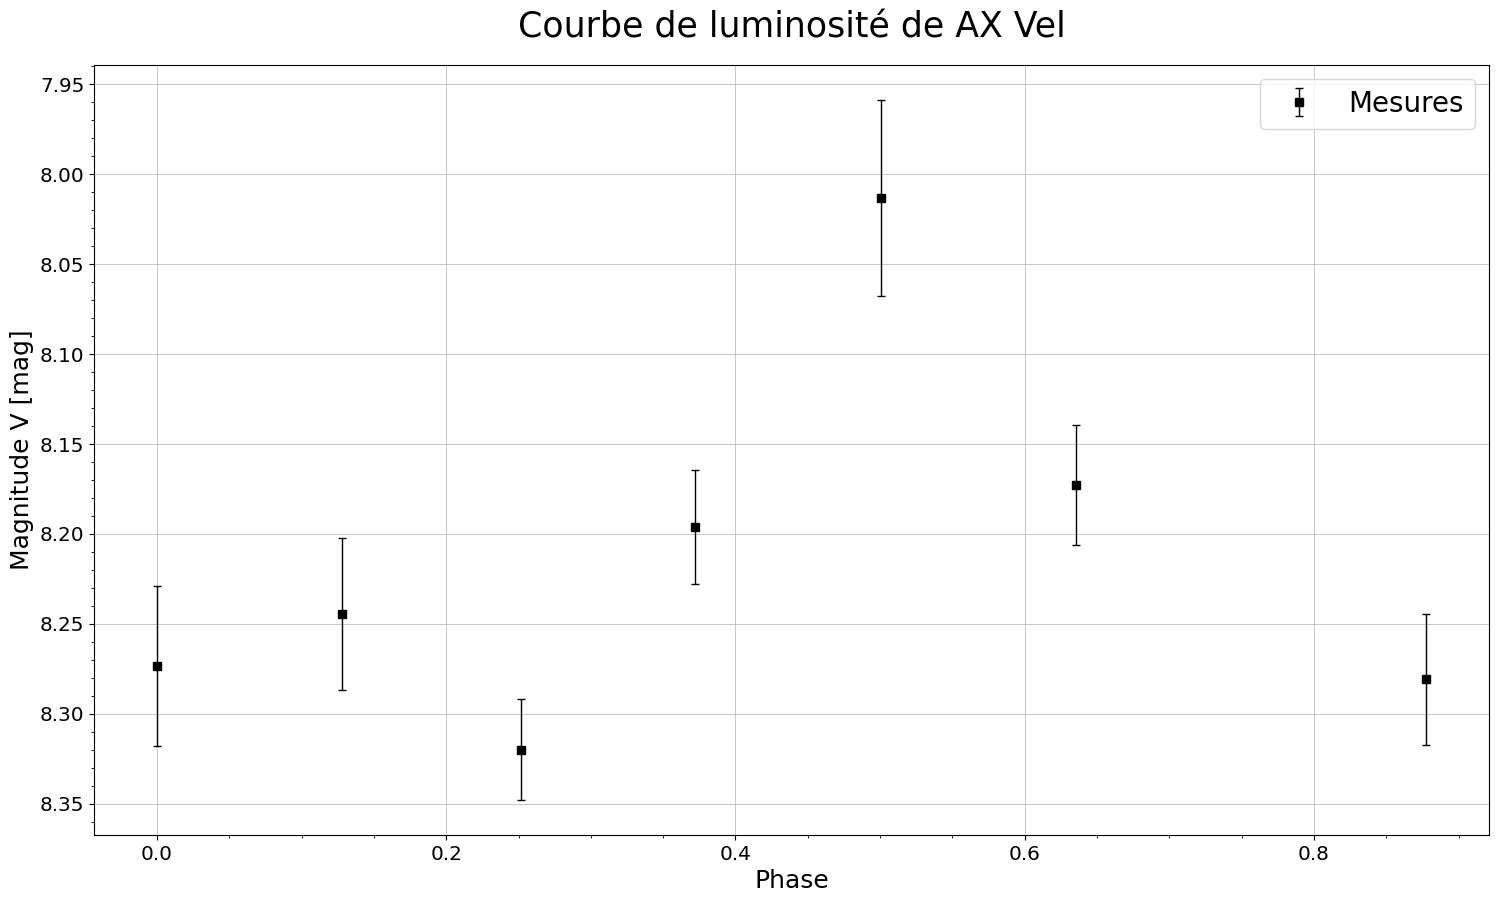

In [8]:
#retrait de l'observation du 16 mai avec .drop(1)

fig, ax = plt.subplots()

ax.errorbar(phase.drop(1), AX_V.drop(1), yerr=AX_SD.drop(1), lw=1, color='k',  capsize=3, marker='s',
            linestyle = 'none', label=('Mesures'))
ax.invert_yaxis()


ax.set_title('Courbe de luminosité de AX Vel', pad=20)
ax.set_ylabel('Magnitude V [mag]')
ax.set_xlabel('Phase')
ax.legend(loc='best', frameon=True)

plt.savefig('graphes/AXVEL_photometry.pdf', bbox_inches='tight')
plt.show()

In [9]:
#fig2, ax2 = plt.subplots()

#ax2.plot(air, AX_SD, color='k', marker='s', linestyle = 'none', label=('Mesures'))

#ax2.set_title('Erreur sur nos mesures en fonction de la hauteur de AX Vel dans le ciel', pad=20)
#ax2.set_ylabel('Ecart type [mag]')
#ax2.set_xlabel("Masse d'air [masse d'air zénitale]")
#ax2.legend(loc='best', frameon=True)

#plt.savefig('graphes/stddev_airmass.pdf', bbox_inches='tight')
#plt.show()

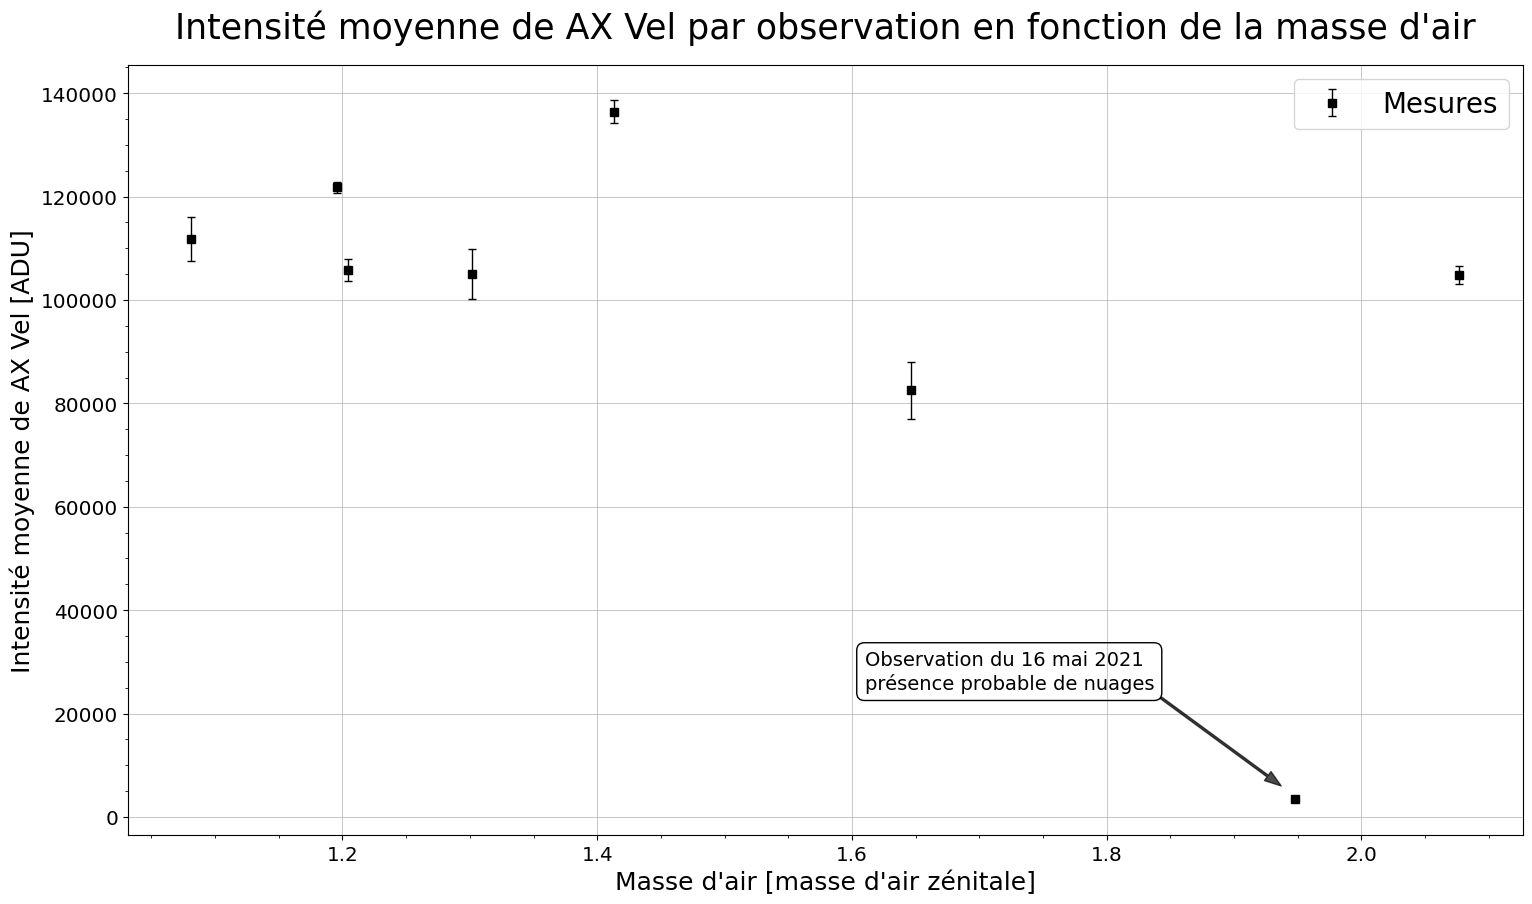

In [10]:
fig3, ax3 = plt.subplots()

ax3.errorbar(air, AX_mean_adu, yerr=AX_SD_adu, lw=1, color='k',  capsize=3, marker='s',
            linestyle = 'none', label=('Mesures'))

ax3.set_title("Intensité moyenne de AX Vel par observation en fonction de la masse d'air", pad=20)
ax3.set_ylabel("Intensité moyenne de AX Vel [ADU]")
ax3.set_xlabel("Masse d'air [masse d'air zénitale]")
ax3.legend(loc='best', frameon=True)



ax3.annotate('Observation du 16 mai 2021\nprésence probable de nuages', xy = (1.937, 6000),  xycoords='data',
                xytext = (-300,70 ), textcoords = 'offset points',
                arrowprops = {'color': 'black', 'width': 1.5,
                              'headwidth': 8, 'alpha': 0.7},
                bbox=dict(boxstyle="round",pad=0.4, fc="none", ec="black"),
                fontsize=14)

plt.savefig('graphes/meanadu_airmass.pdf', bbox_inches='tight')
plt.show()

In [11]:
t = Time([date], format='jd', out_subfmt='date')
date2 = t.tt.datetime[0]

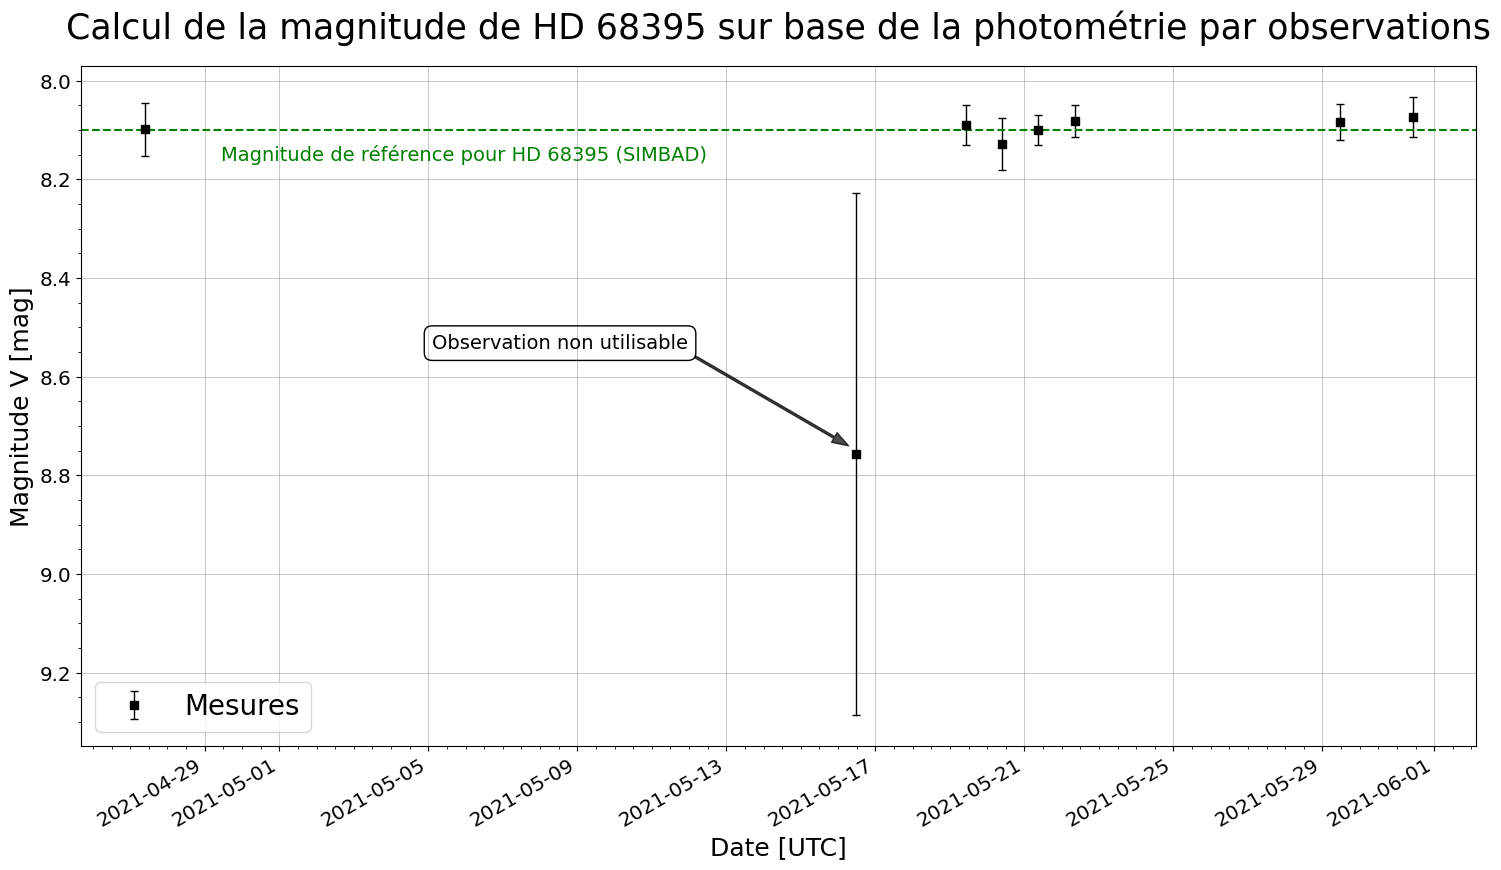

In [41]:
fig4, ax4 = plt.subplots()

ax4.errorbar(date2, HD_V, yerr=HD_SD, lw=1, color='k',  capsize=3, marker='s',
            linestyle = 'none', label=('Mesures'))

ax4.set_title('Calcul de la magnitude de HD 68395 sur base de la photométrie par observations', pad=20)
ax4.set_ylabel('Magnitude V [mag]')
ax4.set_xlabel("Date [UTC]")
ax4.legend(loc='best', frameon=True)
ax4.invert_yaxis()

ax4.axhline(y=8.1, color='g', linestyle='--')
ax4.text(0.1, 0.86,'Magnitude de référence pour HD 68395 (SIMBAD)',
                fontsize=14, color='green', transform=ax4.transAxes)

ax4.annotate('Observation non utilisable', xy = (date2[1]-timedelta(days=0, hours=5, minutes=0), 8.74),
                xycoords='data',
                xytext = (-300,70 ), textcoords = 'offset points',
                arrowprops = {'color': 'black', 'width': 1.5,
                              'headwidth': 8, 'alpha': 0.7},
                bbox=dict(boxstyle="round",pad=0.4, fc="none", ec="black"),
                fontsize=14)

plt.gcf().autofmt_xdate()
plt.savefig('graphes/HD_check.pdf', bbox_inches='tight')
plt.show()

# 2) Comparaison avec les données de l'article de Susan L. Barrell

In [55]:
#Ouverture des datas de susan
data_susan = pd.read_csv('data_susan_barrell.txt',sep=",",index_col=False)

data_susan = (data_susan[data_susan['V [mag]'] < 8.6]) # valeur qui deconne en 8.8

date_susan = data_susan['HJD (-2443000)'] + 2443000
mag_susan = data_susan['V [mag]']

In [39]:
P_susan = 2.592891
mid_susan = 2443878.253 + 1/2*P_susan
phase_susan = np.mod((date_susan-mid_susan)/P_susan,1)

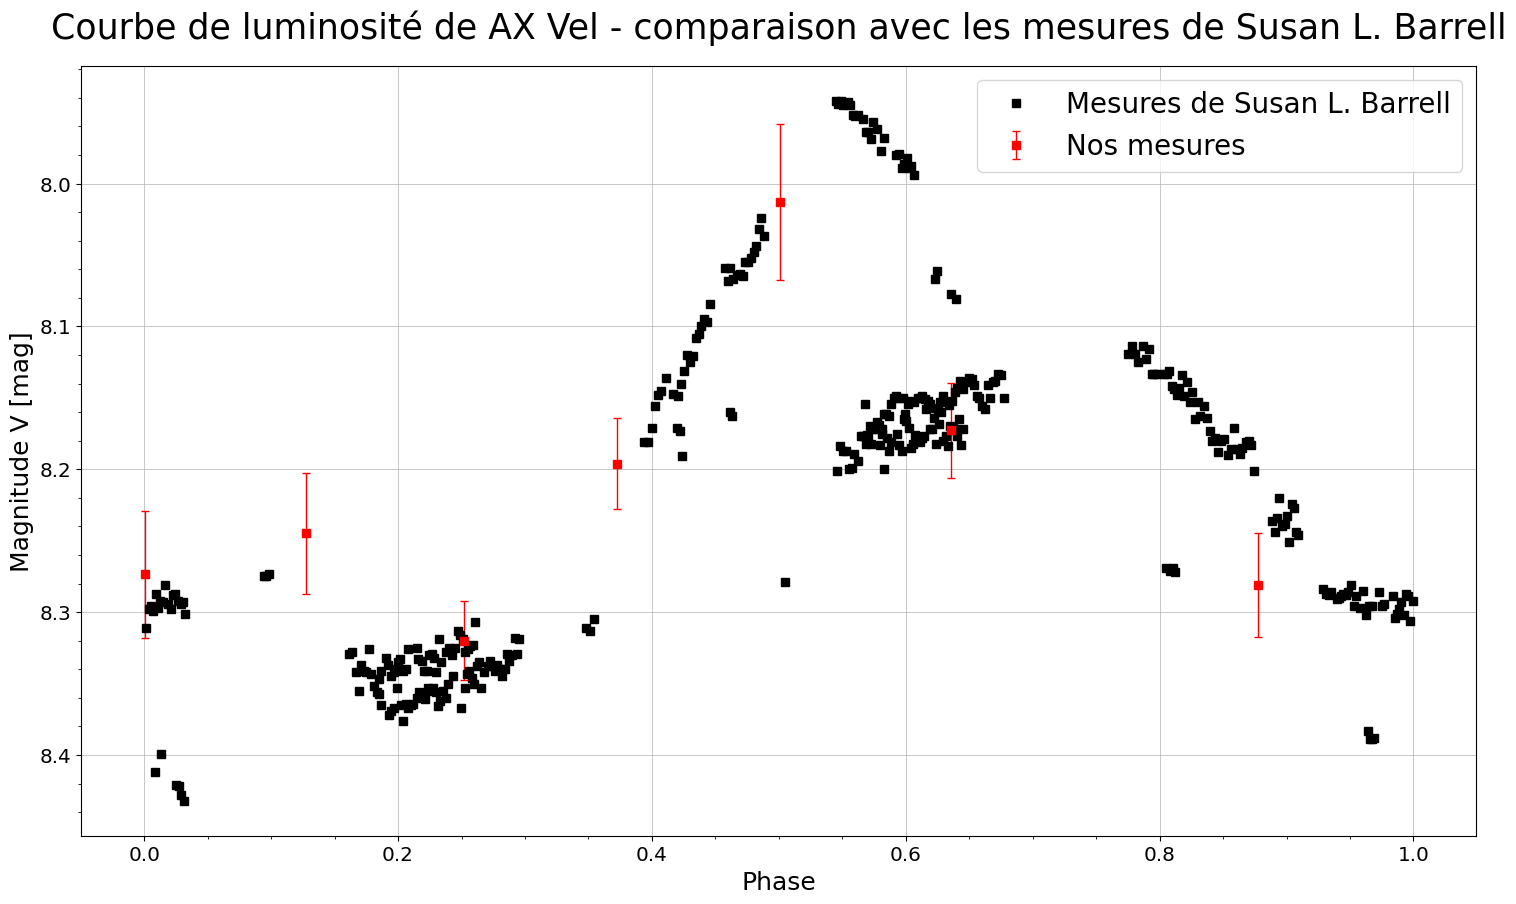

In [53]:
fig, ax = plt.subplots()

ax.plot(phase_susan, mag_susan, lw=1, color='k', marker='s', linestyle = 'none', label=('Mesures de Susan L. Barrell'))
ax.errorbar(phase.drop(1), AX_V.drop(1), yerr=AX_SD.drop(1), lw=1, color='r',  capsize=3, marker='s',
            linestyle = 'none', label=('Nos mesures'))
ax.invert_yaxis()


ax.set_title('Courbe de luminosité de AX Vel - comparaison avec les mesures de Susan L. Barrell', pad=20)
ax.set_ylabel('Magnitude V [mag]')
ax.set_xlabel('Phase')
ax.legend(loc='best', frameon=True)

plt.savefig('graphes/litterature_vs_nous.pdf', bbox_inches='tight')
plt.show()

# 3) Estimation de la distance de AX Vel

In [15]:
p_gaia = 0.6799677466559306E-3 #arcsec
D_th = 1/p_gaia


a = -4.05
b = -2.43
P = 2.592891
m_V = np.mean(AX_V.drop(1)) #sans l'observation raté du 16 mai
K = 6.403
A = 0

M = a + b*(np.log10(P) - 1)
D = 10**((m_V - M + 5 - A) / 5)
err = np.abs((1 - (D/D_th))*100)

print('D =',"{:.2f}".format(D),'[pc]')
print('D_GAIA =',"{:.2f}".format(D_th),'[pc]')
print('Erreur de',"{:.2f}".format(err),'%','par rapport à Gaia')

D = 1472.25 [pc]
D_GAIA = 1470.66 [pc]
Erreur de 0.11 % par rapport à Gaia


# 4) PSF saturé

In [56]:
#PSF AX Vel saturé
data_sature = pd.read_csv('obs_16_mai_sature.txt',sep=" ",index_col=False, na_values=['-9999'])
print(data_sature)

     radius     ADU
0         0  1000.0
1         1     NaN
2         2     NaN
3         3     NaN
4         4     NaN
..      ...     ...
110     110     0.0
111     111     0.0
112     112     0.0
113     113     0.0
114     114     0.0

[115 rows x 2 columns]


In [30]:
#Encodage des datas, selectionner datas 1 to 70: 1= enlever le max 70= cropper les datas
radius = data_sature.iloc[1:70 , 0]
sat_adu = data_sature.iloc[1:70 , 1]

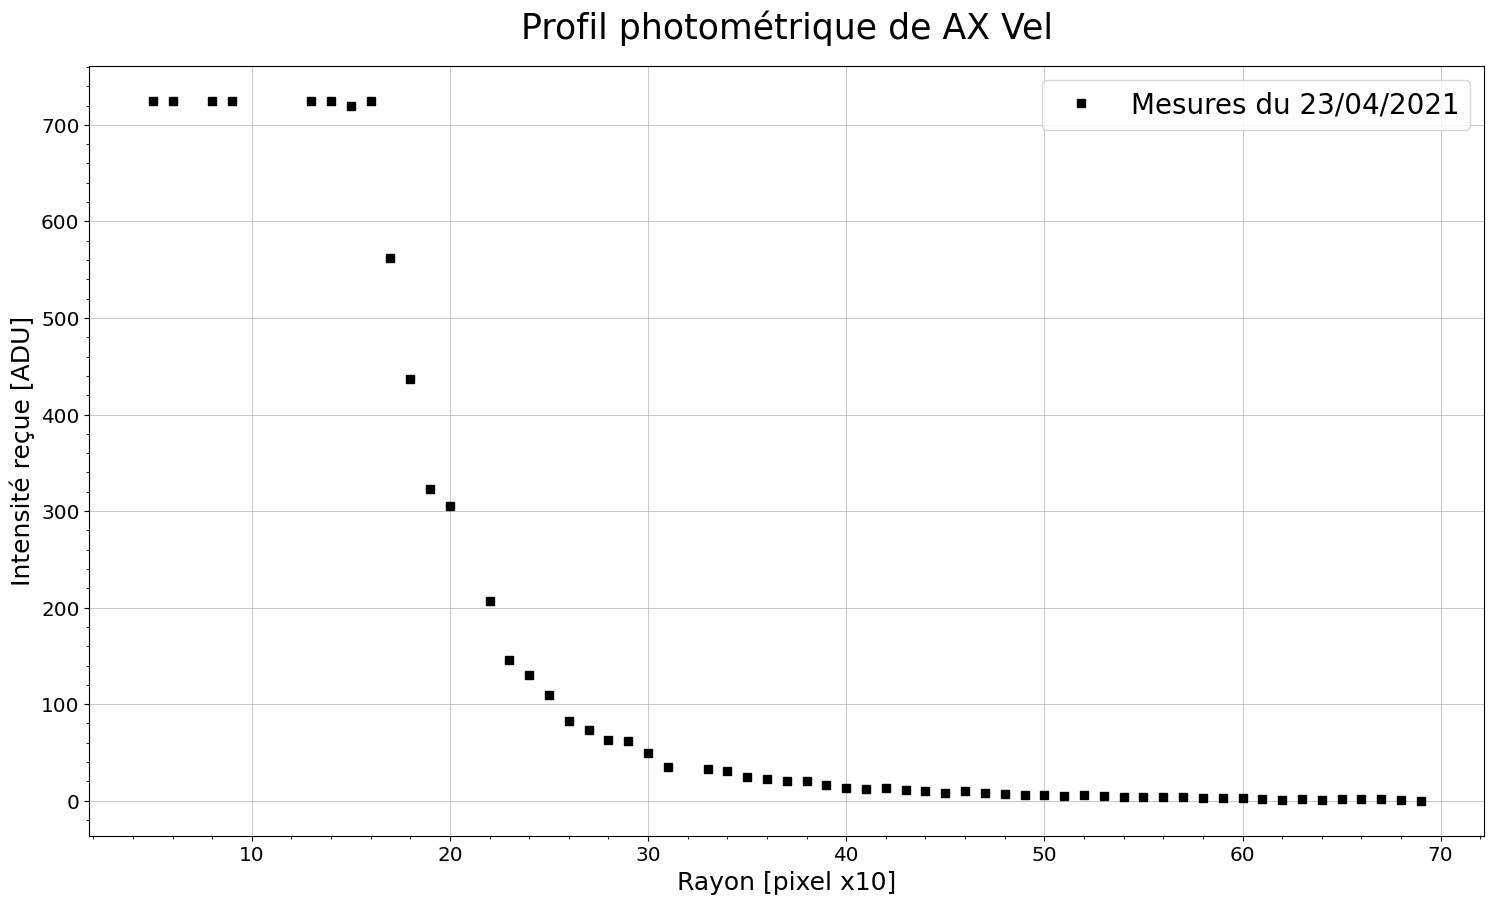

In [31]:
figsat, axsat = plt.subplots()

axsat.plot(radius, sat_adu, color='k', marker = 's', linestyle = "none", label = "Mesures du 23/04/2021")

axsat.set_title('Profil photométrique de AX Vel', pad=20)
axsat.set_xlabel('Rayon [pixel x10]')
axsat.set_ylabel("Intensité reçue [ADU]")
axsat.legend(loc='best', frameon=True)

plt.savefig('graphes/sature.pdf', bbox_inches='tight')
plt.show()

# 5) Etude reglages télescope

In [54]:
#images fournies pour HD5505 - T5
data_T5 = pd.read_csv('ADU_HD5505_T5.txt',sep=",",index_col=False)
print(data_T5)

    exposure [s]     ADU
0              2   25752
1              4   52215
2              8  104886
3             12  156629
4             16  208363
5             20  252273
6             25  304725
7             30  343192
8             35  385778
9             40  418215
10            50  489888
11            60  536291


In [33]:
#Encodage des datas séparation lineaire et quadratique
hd5505_t1 = data_T5.iloc[0:5 , 0]
hd5505_adu1 = data_T5.iloc[0:5 , 1]

hd5505_t2 = data_T5.iloc[5:12 , 0]
hd5505_adu2 = data_T5.iloc[5:12 , 1]

In [34]:
#fit linéaire
coef1 = np.polyfit(hd5505_t1, hd5505_adu1, 1)
print("fit linéaire : f(x) =",coef1[0],"x +",coef1[1])
#fit ^2
coef2 = np.polyfit(hd5505_t2, hd5505_adu2, 2)
print("fit quadratique : g(x) =",coef2[0],"x^2 +",coef2[1],"x +",coef2[2])

fit1 = np.poly1d(coef1)
fit2 = np.poly1d(coef2)

x1 = np.linspace(1,24,100)
x2 = np.linspace(12,62,100)

x_int = 17.8
y_int = 232141

fit linéaire : f(x) = 13040.472560975606 x + 29.03048780490971
fit quadratique : g(x) = -66.2338643146685 x^2 + 12385.324945431847 x + 32687.848857410852


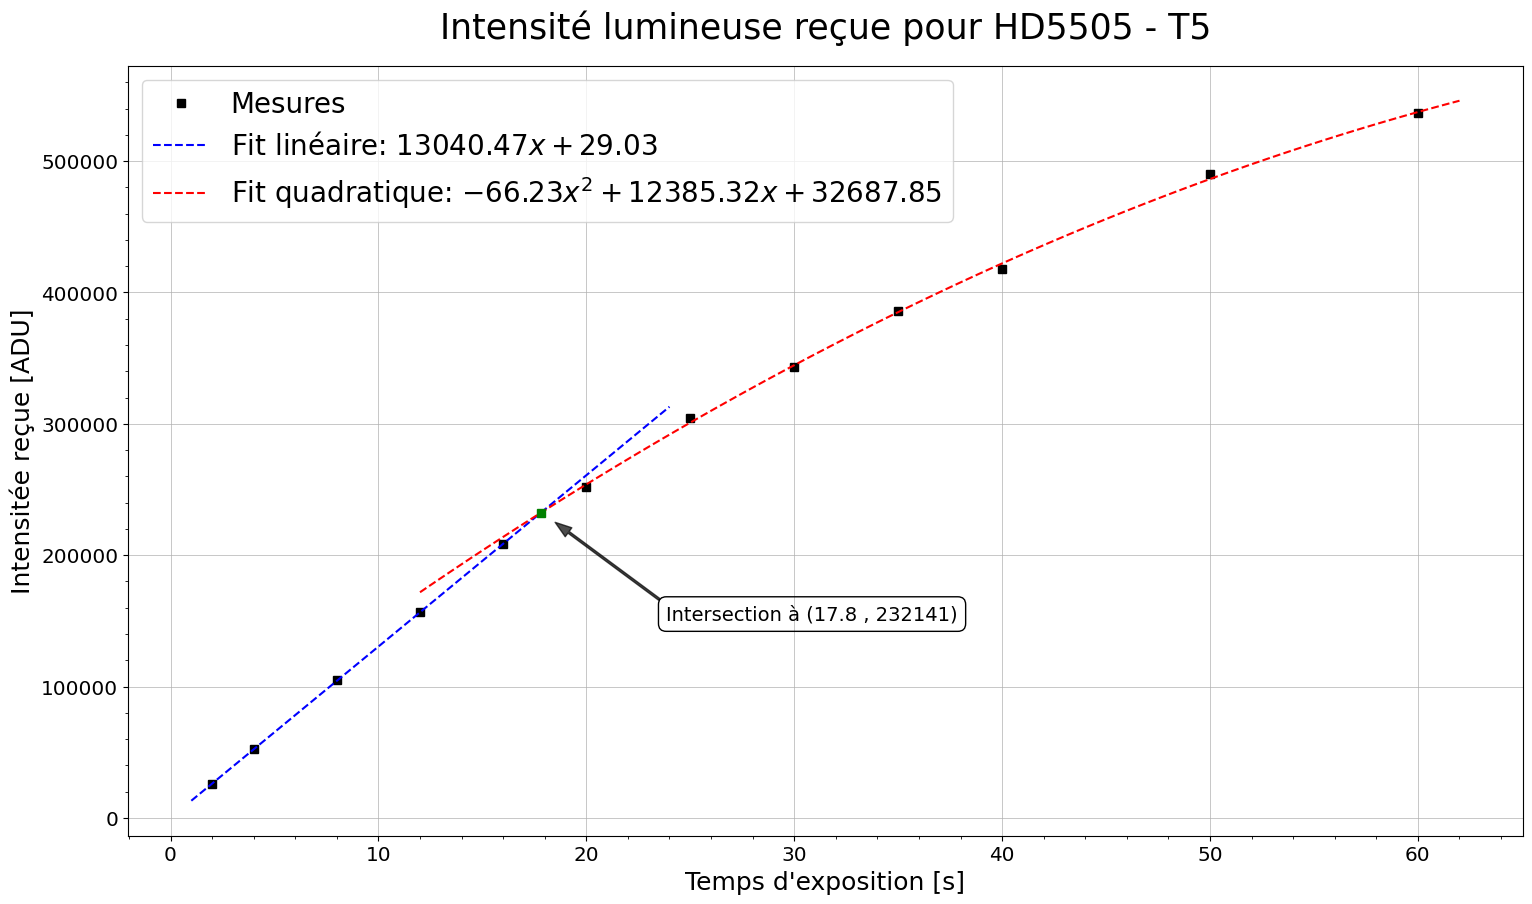

In [35]:
fig0, ax0 = plt.subplots()

ax0.plot(data_T5['exposure [s]'], data_T5['ADU'], color='k', marker='s', linestyle = 'none', label = 'Mesures')

ax0.plot(x1, fit1(x1), color='b', linestyle = '--', label=('Fit linéaire: $13040.47 x + 29.03$'))
ax0.plot(x2, fit2(x2), color='r', linestyle = '--', label=('Fit quadratique: $-66.23 x^2 + 12385.32 x + 32687.85$'))


ax0.plot(x_int, y_int, color='g', marker='s')

ax0.annotate('Intersection à (17.8 , 232141)', xy = (18.5, 225000), xycoords='data',
                xytext = (80,-70 ), textcoords = 'offset points',
                arrowprops = {'color': 'black', 'width': 1.5,
                              'headwidth': 8, 'alpha': 0.7},
                bbox=dict(boxstyle="round",pad=0.4, fc="none", ec="black"),
                fontsize=14)

ax0.set_title('Intensité lumineuse reçue pour HD5505 - T5', pad=20)
ax0.set_ylabel('Intensitée reçue [ADU]')
ax0.set_xlabel("Temps d'exposition [s]")
ax0.legend(loc='best', frameon=True)

plt.savefig('graphes/HD5505_T5.pdf', bbox_inches='tight')
plt.show()

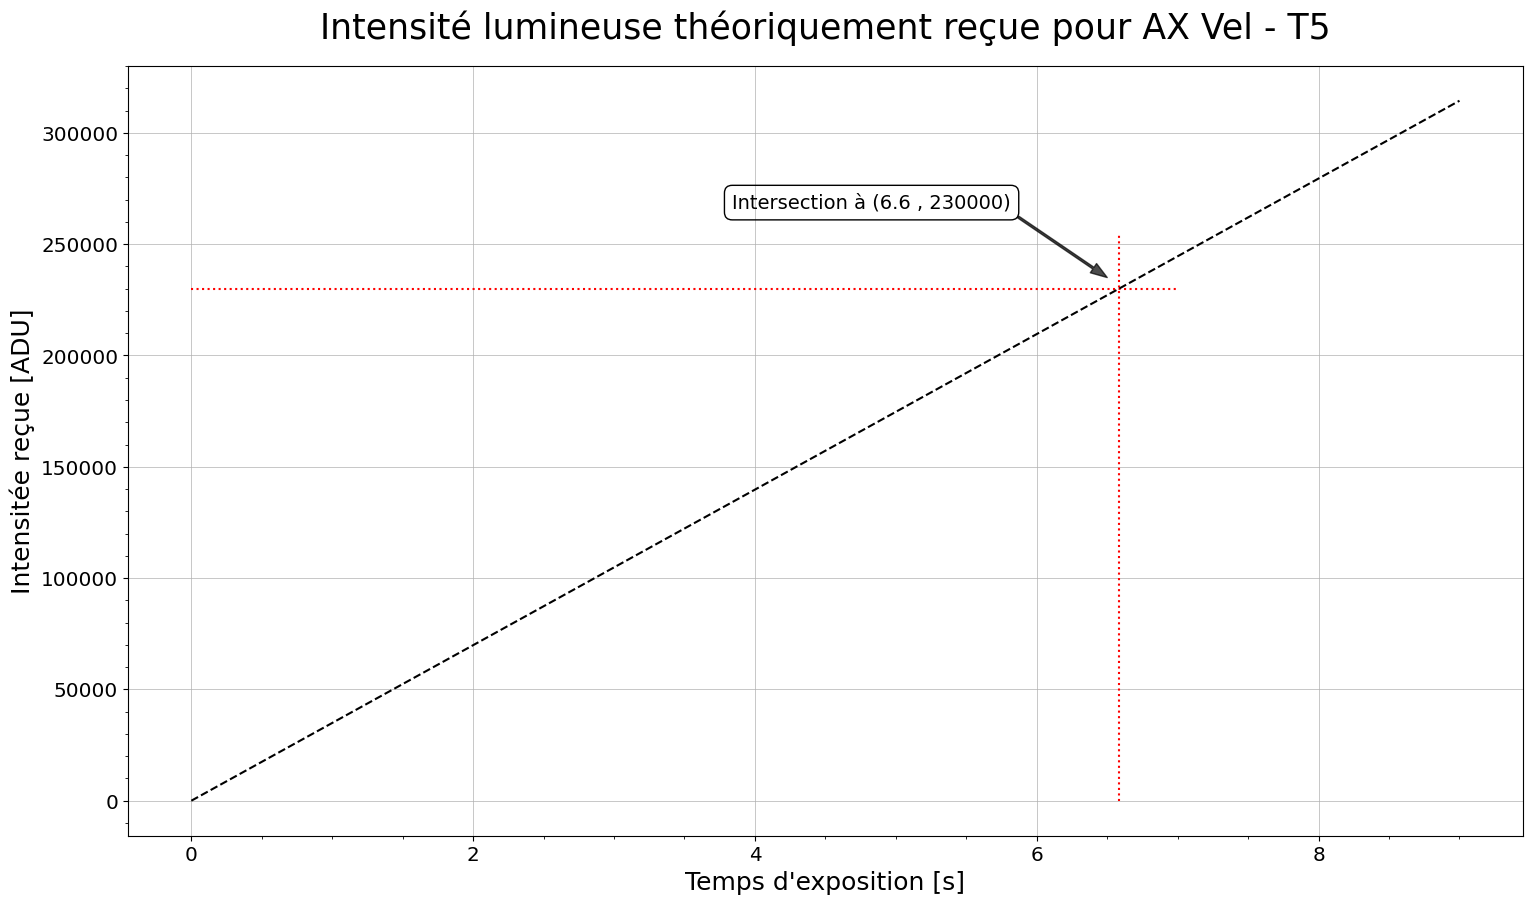

In [36]:
coefn = 34936, 0
fitn = np.poly1d(coefn)
xn = np.linspace(0,9,100)

fign, axn = plt.subplots()

axn.plot(xn, fitn(xn), color='k', linestyle = '--')
axn.hlines(230000,0,7,colors='r', linestyles='dotted')
axn.vlines(6.58346691092283,0,255000,colors='r', linestyles='dotted')

axn.annotate('Intersection à (6.6 , 230000)', xy = (6.5, 235000), xycoords='data',
                xytext = (-270,50 ), textcoords = 'offset points',
                arrowprops = {'color': 'black', 'width': 1.5,
                              'headwidth': 8, 'alpha': 0.7},
                bbox=dict(boxstyle="round",pad=0.4, fc="none", ec="black"),
                fontsize=14)



axn.set_title('Intensité lumineuse théoriquement reçue pour AX Vel - T5', pad=20)
axn.set_ylabel('Intensitée reçue [ADU]')
axn.set_xlabel("Temps d'exposition [s]")
#axn.legend(loc='best', frameon=True)

plt.savefig('graphes/AXVEL_T5.pdf', bbox_inches='tight')
plt.show()